<a href="https://colab.research.google.com/github/HadushHailu/discriminative_few_Shot_face_recognition_and_verification/blob/main/discriminative_few_Shot_face_recognition_and_verification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Discriminative few-shot learning for Face Recognition and Verification**

This study introduces a discriminative few-shot learning approach for face recognition and verification using a Siamese network architecture. Employing a triplet loss function, the model optimizes the embedding space to cluster faces of the same individual and separate those of different individuals, enhancing accuracy and efficiency with limited training data.


---

**Contents**
*   Set up
*   Data collection
*   Load and Pre-process images
*   List item
*   List item
*   List item





# **01 Setup**

## 01_01 Colab specific system-wide setup

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
colab_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', colab_path)
sys.path.insert(0, colab_path)

#01_01 Install Dependencies

In [ ]:
# Installing libraries
!pip install --target=$colab_path retina-face && pip install --target=$colab_path mtcnn && pip install --target=$colab_path openface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.3 MB/s eta 0:00:00


# 01_02 Import Dependencies

In [ ]:
# system libraries
import os
import sys

# core libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np

# Important tensorflow dependencies - functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from tensorflow.keras.metrics import Precision, Recall


# import dependencies of google-colab Image/video viewing
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import PIL
import io
import html
import time

# import face detection libraries
from retinaface import RetinaFace

## 01_03 Set GPU Growth

In [ ]:
# Avoid OOM errors by settings GPU Memeory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print(gpus)

[]


## 01_04 Create Folder Structure

In [ ]:
# Working_Space path
ws_path = '/content/drive/MyDrive/01_colab_data'
data_ws = os.path.join(ws_path, 'data')

In [ ]:
# setup paths
POS_PATH = os.path.join(ws_path, 'data', 'positive')
NEG_PATH = os.path.join(ws_path, 'data', 'negative')
ANC_PATH = os.path.join(ws_path, 'data', 'anchor')

In [ ]:
### Number of negative classes
!cd $ws_path/data/negative && ls -l | wc -l

13320


In [ ]:
### Number of positive classes
!cd $ws_path/data/positive && ls -l | wc -l

333


In [ ]:
### Number of positive classes
!cd $ws_path/data/anchor && ls -l | wc -l

398


# **02 Collect Posetives and Anchors**

## 02_01 Untar Labelled Faces in the wild Dataset¶

In [ ]:
# LFW dataset: http://vis-www.cs.umass.edu/Lfw/
# uncompress Tar GZ Labelled Faces in the wild Dataset
#!tar -xf lfw.tgz

In [ ]:
# Move lfw images to the following repository: data/negative
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw',directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

## 02_02 Collect Positive and Anchor Classes

In [ ]:
# Import uuid library to generate unique names
import uuid

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # Cut-down the frame to 250, 250 pixels size
    frame = frame[100:100+250, 200:200+250, :]

    # Collect anchors dataset
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path
        imgname= os.path.join( ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)

    # Collect positives dataset
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path
        imgname= os.path.join( POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)

    cv2.imshow("Image Collection Frame", frame)

    # breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

# **03  Load and Preprocess Images**

## 03_01 Get Images Directories

In [ ]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(200)
negative_1 = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg', shuffle=False).take(100)
negative = negative.concatenate(negative_1).shuffle(buffer_size=1024)

In [ ]:
dir_test = anchor.as_numpy_iterator()
dir_test.next()


b'/content/drive/MyDrive/01_colab_data/data/anchor/14df28d4-18c4-11ef-9a82-709cd1155f4a.jpg'

## 03_02 Preprocessing - scale and resize

In [ ]:
def preprocess(file_path):
    #print(file_path)
    # Read In image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)
    # Preprocessing step - resize the image to a 100 x 100 x 3
    img = tf.image.resize(img, (100,100))
    # scaling image between 0 and 1
    img = img/255.0

    return img


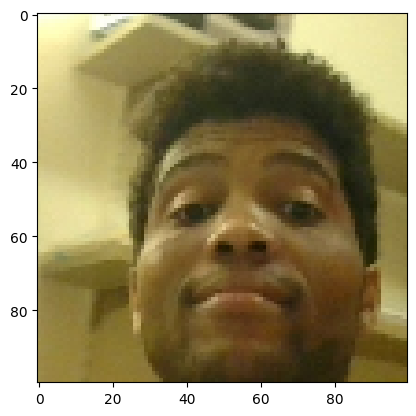

In [ ]:
img = preprocess(dir_test.next())
plt.imshow(img)


## 03_03 Create labelled dataset

In [ ]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)


In [ ]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [ ]:
sample = data.as_numpy_iterator()
sample.next()

(b'/content/drive/MyDrive/01_colab_data/data/anchor/137bf0c6-18c4-11ef-9a82-709cd1155f4a.jpg',
 b'/content/drive/MyDrive/01_colab_data/data/positive/44fb1204-187d-11ef-b95a-709cd1155f4a.jpg',
 1.0)

In [ ]:
len(data)

600

## 03_04 Build train and test partitions


In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img),preprocess(validation_img), label)

In [ ]:
res = preprocess_twin(*sample.next())
res[0].numpy().shape

(100, 100, 3)

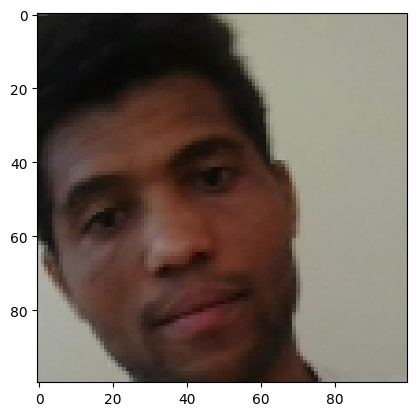

In [ ]:
plt.imshow(res[1])

In [ ]:
res[2]

1.0

In [ ]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [ ]:
# Training partition
train_data = data.take(round(len(data) * 0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [ ]:
# Test partition
test_data = data.skip(round(len(data) * 0.7))
test_data = test_data.take(round(len(data) * 0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# **04 Model Engineering**

## 04_01 Building an embedding layer

In [ ]:
def make_embedding():
    inp = Input(shape = (100,100,3), name = 'Input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Thrid block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final blcok
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs = [inp] , outputs = [d1], name = 'embedding')

In [ ]:
embedding = make_embedding()

In [ ]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

## 04_02 Create an L1 distance layer

In [ ]:
# Siamese L1 Distance class
class L1Dist(Layer):
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [ ]:
l1 = L1Dist()
#l1(anchor_embedding, validation_embedding)

## 04_03 Compile the Siamese Network

In [ ]:
def make_siamese_model():
    # Anchor image input in the network
    input_image = Input(name = 'input_img', shape = (100,100,3))
    # Validation image in the network
    validation_image = Input(name = 'validation_img', shape = (100,100,3))

    # combine saimese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    return Model(inputs=[input_image, validation_image], outputs=classifier, name = 'SiameseNetwork')

In [ ]:
siamese_model =  make_siamese_model()

In [ ]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# **05 Training the Network**

## 05_01 Set up a Loss function and Optimizer

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [ ]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 05_02 Establish Checkpoints

In [ ]:
checkpoint_dir  = os.path.join(data_ws, 'training_checkpoints')
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, simamese_model=siamese_model)

## 05_03 Build a custom training step

In [ ]:
@tf.function
def train_step(batch):
    # Record of all operations
    with tf.GradientTape() as tape:
        # GEt anchor and posetive images
        x = batch[:2]
        # Get labels
        y = batch[2]

        # Forward pass
        y_hat = siamese_model(x, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, y_hat)

    print(loss)

    # Calculate Gradient
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # calculate updated weight and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

## 05_04 Create a Training loop

In [ ]:
def train(data, EPOCHS):
    # loop through epochs
    for epoch in range(1, EPOCHS + 1):
        print('\n EPOCH {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)

        # save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

## 05_05 Train the Model

In [ ]:
EPOCHS = 50

In [ ]:
train(train_data, EPOCHS)

# **06 Evaluate the Model**

## 06_01 Make Predictions

In [ ]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 146ms/step


array([[1.4931759e-08],
       [3.3426986e-07],
       [1.0000000e+00],
       [1.0000000e+00],
       [8.2310462e-06],
       [1.1335920e-05],
       [3.7401360e-08],
       [1.0000000e+00],
       [7.7549211e-09],
       [9.9999273e-01],
       [2.1301112e-07],
       [9.9999940e-01],
       [7.5306212e-05],
       [9.9999976e-01],
       [1.7939110e-06],
       [5.0124063e-06]], dtype=float32)

In [ ]:
# Post processing the results
[1 if prediction > 0.85 else 0 for prediction in y_hat]

[0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0]

In [ ]:
# Create a metric object
m  = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return recall result
m.result().numpy()

1.0

## 06_02 Viz Result¶

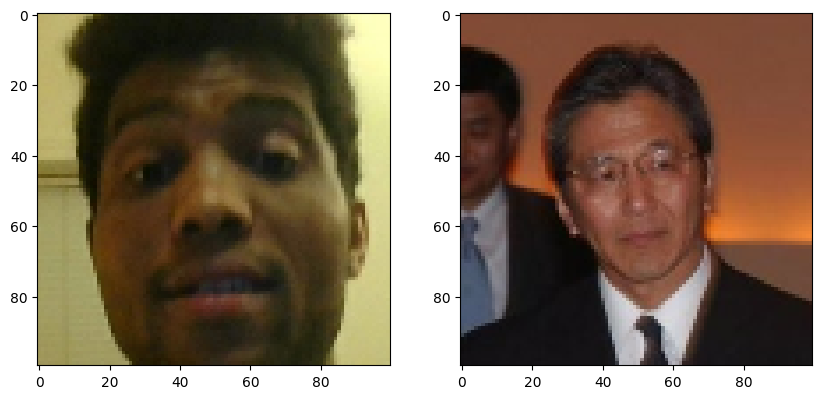

In [ ]:
# set plt size
plt.figure(figsize = (10,8))

# set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[10])

# set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[10])
plt.show()

## 06_03 Save The model

In [ ]:
# Save the model
model_ws = os.path.join(data_ws, 'siamesemodel.h5')
siamese_model.save(model_ws)

NameError: name 'os' is not defined

# **07 Model Evaluation**

## 07_01 Reload the Model

In [ ]:
# Reload the model
model_ws = os.path.join(data_ws, 'siamesemodel.h5')
model = tf.keras.models.load_model(model_ws,
                                 custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})


In [ ]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
model.predict([test_input, test_val])

1/1 [==============================] - 6s 6s/step


array([[1.0000000e+00],
       [1.6175993e-05],
       [1.0000000e+00],
       [7.7492598e-07],
       [1.0000000e+00],
       [9.9999785e-01],
       [1.0000000e+00],
       [1.3230002e-05],
       [9.9581630e-06],
       [9.9999982e-01],
       [1.0000000e+00],
       [6.0887623e-07],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9999815e-01],
       [1.9571300e-05]], dtype=float32)

In [ ]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

## 07_02 Evaluation Metric

In [ ]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()


In [ ]:
y_hat = model.predict([test_input, test_val])

1/1 [==============================] - 4s 4s/step


In [ ]:
y_pred = (y_hat > 0.5).astype(int)

In [ ]:
y_pred

array([[1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1]])

In [ ]:
new_y = np.array(y_pred.flatten() == y_true.flatten())

In [ ]:
new_y

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [ ]:
print(y_true[0])

1.0


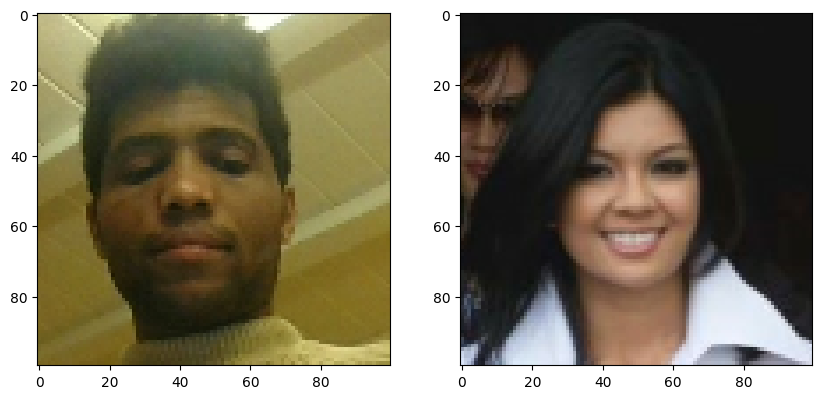

In [ ]:
# set plt size
plt.figure(figsize = (10,8))

# set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[7])

# set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[7])
plt.show()

In [ ]:
# # Placeholder for accuracy and loss lists
# loss_fn = tf.keras.losses.BinaryCrossentropy()
# num_batches = 10
# accuracies = []
# losses = []

# # Example loop to simulate collection of accuracy and loss over multiple batches/epochs
# num_batches = 10  # Number of batches or epochs
# for _ in range(num_batches):
#     test_input, test_val, y_true = test_data.as_numpy_iterator().next()
#     y_hat = model.predict([test_input, test_val])

#     y_pred = (y_hat > 0.5).astype(int)
#     accuracy = np.sum(y_pred.flatten() == y_true.flatten())
#     accuracy_percentage = (accuracy / len(y_true)) * 100
#     print('{} {} {}'.format(y_pred.size, accuracy,accuracy_percentage ))
#     loss_fn = tf.keras.losses.BinaryCrossentropy()
#     loss = loss_fn(y_true, y_hat).numpy()

#     accuracies.append(accuracy_percentage)
#     losses.append(loss)

# # Plot accuracy
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.plot(accuracies, marker='o', linestyle='-', color='b')
# plt.title('Accuracy over Batches/Epochs')
# plt.xlabel('Batch/Epoch')
# plt.ylabel('Accuracy')
# plt.grid(True)

# plt.tight_layout()
# plt.show()

## **08 Testing**

In [ ]:
app_ws = os.path.join(ws_path, 'application_data')

## 08_01 Face Verification

In [ ]:
from functools import wraps
import sys
import io


def capture_output(func):
    """Wrapper to capture print output."""

    @wraps(func)
    def wrapper(*args, **kwargs):
        old_stdout = sys.stdout
        new_stdout = io.StringIO()
        sys.stdout = new_stdout
        try:
            return func(*args, **kwargs)
        finally:
            sys.stdout = old_stdout

    return wrapper

In [ ]:
def verify(frame, model, detection_threshold, verification_threshold):
    # building result array
    results = []
    for image in os.listdir(os.path.join(app_ws, 'verification_images')):
        input_image = preprocess(os.path.join(app_ws, 'input_image', 'input_images.jpg'))
        validation_image = preprocess(os.path.join(app_ws, 'verification_images', image))

        # Make predictions
        result = model.predict(list(np.expand_dims([input_image, validation_image], axis=1)))
        results.append(result)

    # Detection threshold: Metric above which a prediction is considered posetive
    detection = np.sum(np.array(results) > detection_threshold)

    # Verification threshold: proportion of positive predictions/total positive samples
    verification = detection/ len(os.listdir(os.path.join(app_ws, 'verification_images')))
    verified= verification > verification_threshold
    return results, verified


## 08_02 Javascript for displaying Images

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
def take_photo(filename='input_image.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)

  # Detect faces in the image
  faces = RetinaFace.detect_faces(img)

  # Iterate over detected faces and draw bounding boxes
  for face_id, face_info in faces.items():
      facial_area = face_info['facial_area']
      score = face_info['score']
      landmarks = face_info['landmarks']

      x1, y1, x2, y2 = facial_area

      # Draw the bounding box
      cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

      #
      this_face = img[y1:y2, x1:x2]
      input_image_ws = os.path.join(app_ws, 'input_image', 'input_images.jpg')
      cv2.imwrite(input_image_ws, this_face)

      w_detect_face = capture_output(verify)

      results, verified = w_detect_face(this_face, model, 0.5, 0.75)


      # Prepare the label with the score
      label = f'Score: {score:.2f} Verified: {verified} Conf: {np.sum(np.array(results)/50)}'

      # Set font parameters
      font = cv2.FONT_HERSHEY_SIMPLEX
      font_scale = 0.5
      font_color = (255, 0, 0)
      font_thickness = 2

      # Landmarks
      for landmark in landmarks.values():
        x, y = landmark
        cv2.circle(img, (int(x), int(y)), 5, (0, 255, 0), -1)

      # Calculate the position for the text
      text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
      text_x = x1
      text_y = y1 - 10 if y1 - 10 > 10 else y1 + text_size[1] + 10

      # Put the label above the bounding box
      cv2.putText(img, label, (text_x, text_y), font, font_scale, font_color, font_thickness)

  # Display the image with bounding boxes
  cv2.imwrite(filename, img)

  return filename

## 07_03 Verify Image from Video Capture

<IPython.core.display.Javascript object>

Saved to photo.jpg


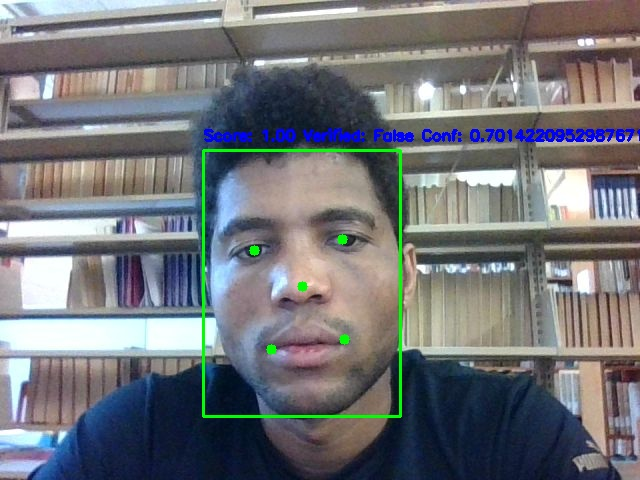

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## 07_04 Real-Time Verification from video stream

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
start = False

while start:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    faces = RetinaFace.detect_faces(frame)
    # Iterate over detected faces and draw bounding boxes
    for face_id, face_info in faces.items():
        facial_area = face_info['facial_area']
        score = face_info['score']
        landmarks = face_info['landmarks']

        x1, y1, x2, y2 = facial_area

        # Draw the bounding box
        cv2.rectangle(bbox_array, (x1, y1), (x2, y2), (0, 255, 0), 2)

        #
        this_face = frame[y1:y2, x1:x2]
        input_image_ws = os.path.join(app_ws, 'input_image', 'input_images.jpg')
        cv2.imwrite(input_image_ws, this_face)

        w_detect_face = capture_output(verify)

        results, verified = w_detect_face(this_face, model, 0.5, 0.75)


        # Prepare the label with the score
        label = f'Score: {score:.2f} Verified: {verified} Conf: {np.sum(np.array(results)/50)}'

        # Set font parameters
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_color = (255, 0, 0)
        font_thickness = 2

        # Landmarks
        for landmark in landmarks.values():
          x, y = landmark
          cv2.circle(bbox_array, (int(x), int(y)), 5, (0, 255, 0), -1)

        # Calculate the position for the text
        text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
        text_x = x1
        text_y = y1 - 10 if y1 - 10 > 10 else y1 + text_size[1] + 10

        # Put the label above the bounding box
        cv2.putText(bbox_array, label, (text_x, text_y), font, font_scale, font_color, font_thickness)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>